In [1]:
import copy
import numpy as np
from qiskit import Aer, IBMQ, execute, QuantumCircuit, circuit, pulse, transpile, schedule, assemble
from qiskit.providers.aer.pulse.system_models.pulse_system_model import PulseSystemModel
from qiskit.providers.aer.backends import PulseSimulator

import matplotlib.pyplot as plt

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='dev-sys-software', project='internal-test')

/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
backend = provider.get_backend('ibmq_armonk')

In [4]:
config = backend.configuration()
defaults = backend.defaults()

In [5]:
hamiltonian = config.hamiltonian
print(hamiltonian['h_str'])
print(hamiltonian['osc'])
print(hamiltonian['vars'])

['_SUM[i,0,0,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,0,delta{i}/2*O{i}*O{i}]', '_SUM[i,0,0,-delta{i}/2*O{i}]', '_SUM[i,0,0,omegad{i}*X{i}||D{i}]']
{}
{'delta0': 0, 'omegad0': 0.03672940823863659, 'wq0': 31.255348447861333}


In [6]:
config.dt

2.2222222222222221e-10

## Original Model

In [7]:
orig_model = PulseSystemModel.from_backend(backend)

In [8]:
qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0, 0)

In [9]:
sched = schedule(transpile(qc, backend), backend)

In [10]:
sim = PulseSimulator()

In [11]:
qobj = assemble(sched, backend=sim)

/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_p

In [12]:
job = sim.run(qobj, system_model=orig_model)

In [13]:
result = job.result()

In [14]:
result.get_counts()

{'0': 1024}

## Modified Model

In [15]:
new_backend = copy.deepcopy(backend)
new_config = new_backend.configuration()
new_defaults = new_backend.defaults()

In [16]:
new_hamiltonian = new_config.hamiltonian

### Modifications

In [17]:
new_hamiltonian['vars'] = {k: v*1e9 for k, v in new_hamiltonian['vars'].items()}
new_hamiltonian['qub'] = {k: 3 for k in new_hamiltonian['qub'].keys()}
new_hamiltonian['vars']['omegad0'] = new_hamiltonian['vars']['omegad0']*2
new_hamiltonian['vars']['delta0'] = -330e7

In [18]:
hamiltonian = config.hamiltonian
print(new_hamiltonian['h_str'])
print(new_hamiltonian['osc'])
print(new_hamiltonian['qub'])
print(new_hamiltonian['vars'])

['_SUM[i,0,0,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,0,delta{i}/2*O{i}*O{i}]', '_SUM[i,0,0,-delta{i}/2*O{i}]', '_SUM[i,0,0,omegad{i}*X{i}||D{i}]']
{}
{'0': 3}
{'delta0': -3300000000.0, 'omegad0': 73458816.47727318, 'wq0': 31255348447.861332}


In [19]:
new_model = PulseSystemModel.from_backend(new_backend)

In [20]:
job = sim.run(qobj, system_model=new_model)

In [21]:
result = job.result()

In [22]:
result.get_counts()

{'0': 46, '1': 978}

In [23]:
new_defaults.qubit_freq_est

[4974443203.53673]

# 2Q Backend

## Original

In [24]:
backend_2q = provider.get_backend('ibmq_manhattan')

In [25]:
orig_config_2q = backend_2q.configuration()
orig_defaults_2q = backend_2q.defaults()

In [26]:
orig_model_2q = PulseSystemModel.from_backend(backend_2q, subsystem_list=[0, 1])

In [27]:
orig_hamiltonian_2q = orig_config_2q.hamiltonian
print(orig_hamiltonian_2q['h_str'])
print(orig_hamiltonian_2q['osc'])
print(orig_hamiltonian_2q['vars'])

['_SUM[i,0,64,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,64,delta{i}/2*O{i}*O{i}]', '_SUM[i,0,64,-delta{i}/2*O{i}]', '_SUM[i,0,64,omegad{i}*X{i}||D{i}]', 'jq42q43*Sp42*Sm43', 'jq42q43*Sm42*Sp43', 'jq22q23*Sp22*Sm23', 'jq22q23*Sm22*Sp23', 'jq36q37*Sp36*Sm37', 'jq36q37*Sm36*Sp37', 'jq28q29*Sp28*Sm29', 'jq28q29*Sm28*Sp29', 'jq53q60*Sp53*Sm60', 'jq53q60*Sm53*Sp60', 'jq61q62*Sp61*Sm62', 'jq61q62*Sm61*Sp62', 'jq5q6*Sp5*Sm6', 'jq5q6*Sm5*Sp6', 'jq8q9*Sp8*Sm9', 'jq8q9*Sm8*Sp9', 'jq34q35*Sp34*Sm35', 'jq34q35*Sm34*Sp35', 'jq18q19*Sp18*Sm19', 'jq18q19*Sm18*Sp19', 'jq23q26*Sp23*Sm26', 'jq23q26*Sm23*Sp26', 'jq0q10*Sp0*Sm10', 'jq0q10*Sm0*Sp10', 'jq51q54*Sp51*Sm54', 'jq51q54*Sm51*Sp54', 'jq59q60*Sp59*Sm60', 'jq59q60*Sm59*Sp60', 'jq30q31*Sp30*Sm31', 'jq30q31*Sm30*Sp31', 'jq46q47*Sp46*Sm47', 'jq46q47*Sm46*Sp47', 'jq31q32*Sp31*Sm32', 'jq31q32*Sm31*Sp32', 'jq63q64*Sp63*Sm64', 'jq63q64*Sm63*Sp64', 'jq49q50*Sp49*Sm50', 'jq49q50*Sm49*Sp50', 'jq1q2*Sp1*Sm2', 'jq1q2*Sm1*Sp2', 'jq16q17*Sp16*Sm17', 'jq16q17*Sm16*Sp17', 'j

In [28]:
bell = QuantumCircuit(2, 2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0, 1], [0, 1])

In [29]:
channels_to_drop = ([pulse.AcquireChannel(i) for i in range(2, orig_config_2q.n_qubits)]+
                    [pulse.MeasureChannel(i) for i in range(2, orig_config_2q.n_qubits)]+
                    [pulse.ControlChannel(0), pulse.ControlChannel(4), pulse.ControlChannel(21)])

In [30]:
bell_sched = schedule(transpile(bell, backend_2q), backend_2q).exclude(channels=channels_to_drop)

In [31]:
bell_qobj = assemble(bell_sched, backend=sim)

/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` inst

In [32]:
job = sim.run(bell_qobj, system_model=orig_model_2q)

In [33]:
result = job.result()

In [34]:
result.get_counts()

{'00': 1024}

## Modified Model

In [35]:
new_backend_2q = copy.deepcopy(backend_2q)

In [36]:
new_config_2q = new_backend_2q.configuration()
new_defaults_2q = new_backend_2q.defaults()

In [37]:
new_hamiltonian_2q = new_config_2q.hamiltonian
print(new_hamiltonian_2q['h_str'])
print(new_hamiltonian_2q['osc'])
print(new_hamiltonian_2q['vars'])

['_SUM[i,0,64,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,64,delta{i}/2*O{i}*O{i}]', '_SUM[i,0,64,-delta{i}/2*O{i}]', '_SUM[i,0,64,omegad{i}*X{i}||D{i}]', 'jq42q43*Sp42*Sm43', 'jq42q43*Sm42*Sp43', 'jq22q23*Sp22*Sm23', 'jq22q23*Sm22*Sp23', 'jq36q37*Sp36*Sm37', 'jq36q37*Sm36*Sp37', 'jq28q29*Sp28*Sm29', 'jq28q29*Sm28*Sp29', 'jq53q60*Sp53*Sm60', 'jq53q60*Sm53*Sp60', 'jq61q62*Sp61*Sm62', 'jq61q62*Sm61*Sp62', 'jq5q6*Sp5*Sm6', 'jq5q6*Sm5*Sp6', 'jq8q9*Sp8*Sm9', 'jq8q9*Sm8*Sp9', 'jq34q35*Sp34*Sm35', 'jq34q35*Sm34*Sp35', 'jq18q19*Sp18*Sm19', 'jq18q19*Sm18*Sp19', 'jq23q26*Sp23*Sm26', 'jq23q26*Sm23*Sp26', 'jq0q10*Sp0*Sm10', 'jq0q10*Sm0*Sp10', 'jq51q54*Sp51*Sm54', 'jq51q54*Sm51*Sp54', 'jq59q60*Sp59*Sm60', 'jq59q60*Sm59*Sp60', 'jq30q31*Sp30*Sm31', 'jq30q31*Sm30*Sp31', 'jq46q47*Sp46*Sm47', 'jq46q47*Sm46*Sp47', 'jq31q32*Sp31*Sm32', 'jq31q32*Sm31*Sp32', 'jq63q64*Sp63*Sm64', 'jq63q64*Sm63*Sp64', 'jq49q50*Sp49*Sm50', 'jq49q50*Sm49*Sp50', 'jq1q2*Sp1*Sm2', 'jq1q2*Sm1*Sp2', 'jq16q17*Sp16*Sm17', 'jq16q17*Sm16*Sp17', 'j

### Modifications

In [38]:
new_hamiltonian_2q['vars'] = {k: v*1e9 for k, v in new_hamiltonian_2q['vars'].items()}
new_hamiltonian_2q['qub'] = {k: 3 for k in new_hamiltonian_2q['qub'].keys()}
new_hamiltonian_2q['vars']['omegad0'] = new_hamiltonian_2q['vars']['omegad0']*2
new_hamiltonian_2q['vars']['omegad1'] = new_hamiltonian_2q['vars']['omegad1']*2
new_hamiltonian_2q['vars']['jq0q1'] = 2*new_hamiltonian_2q['vars']['jq0q1']
new_hamiltonian_2q['vars']['jq0q1']

24586252.644960392

In [39]:
new_model_2q = PulseSystemModel.from_backend(new_backend_2q, subsystem_list=[0, 1])

In [40]:
bell_qobj = assemble(bell_sched, backend=sim)
job = sim.run(bell_qobj, system_model=new_model_2q)

/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` inst

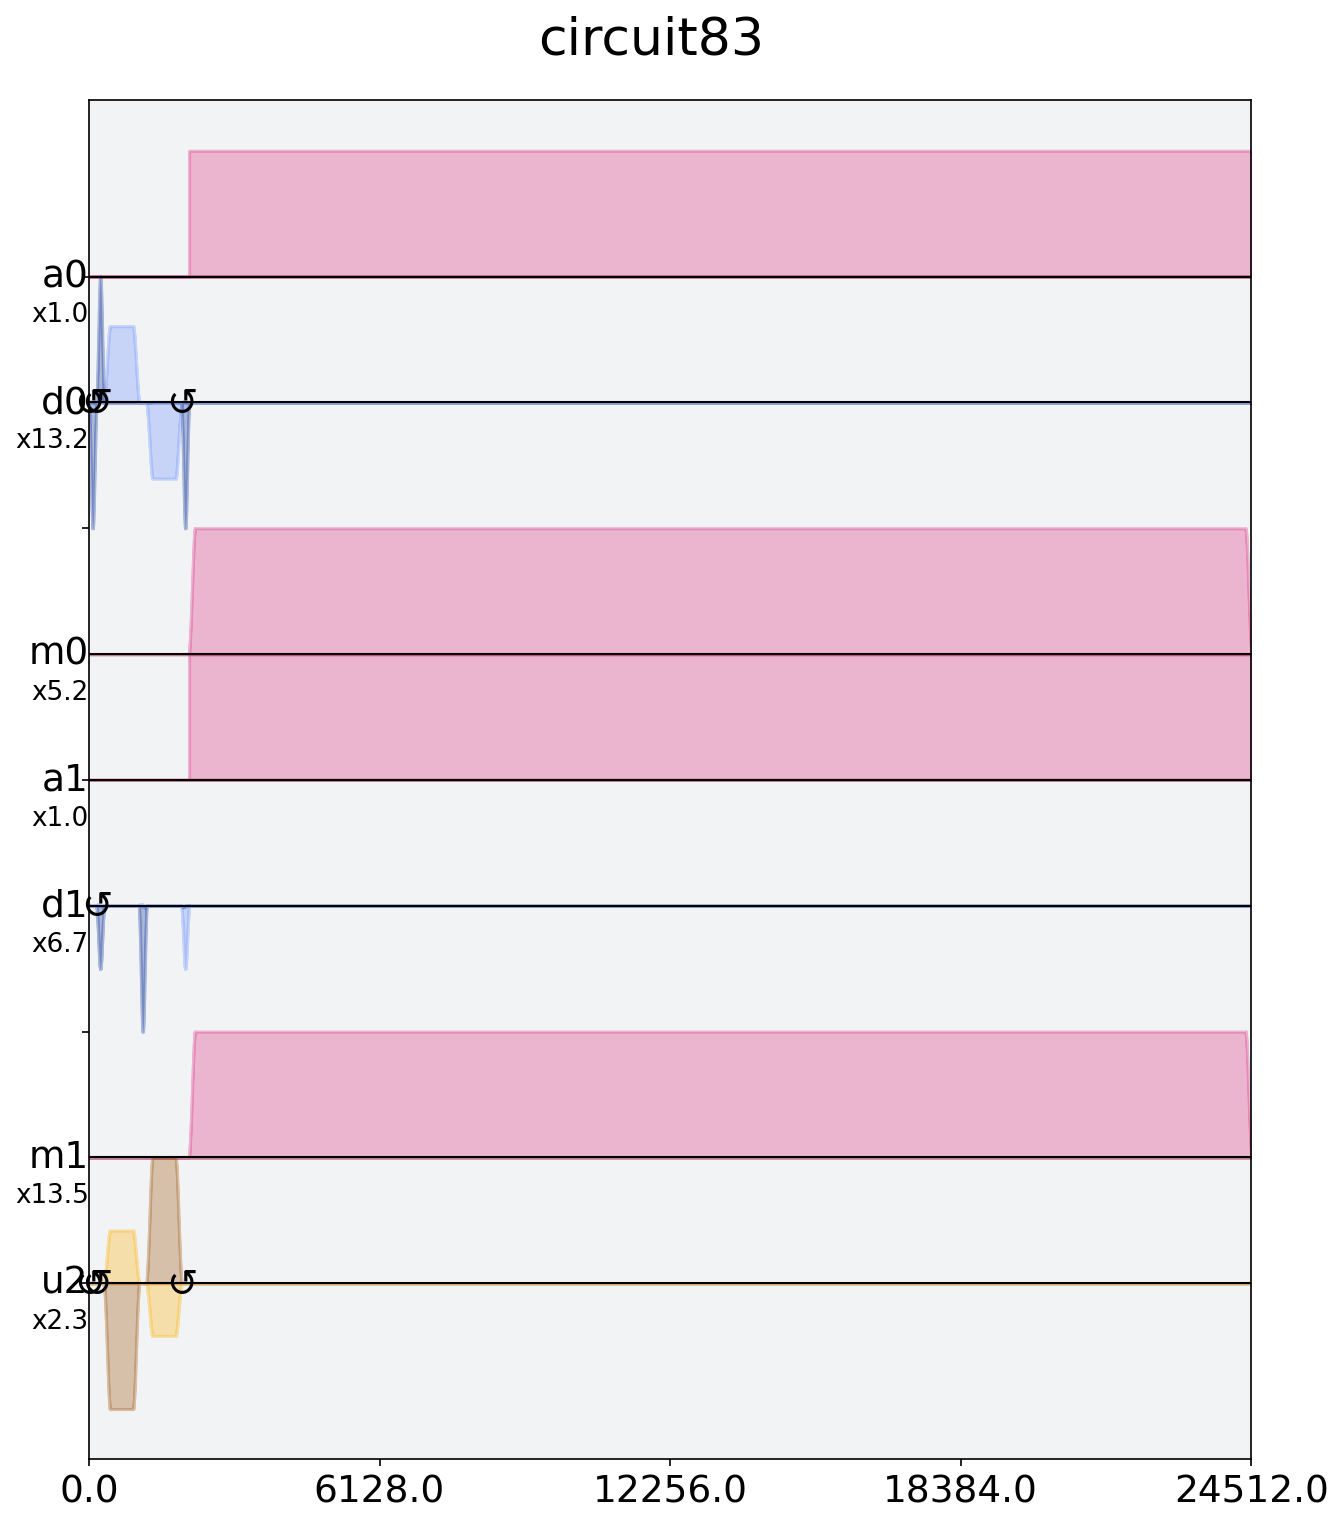

In [41]:
bell_sched.draw()

In [42]:
result = job.result()

In [43]:
result.get_counts()

{'00': 408, '01': 245, '10': 233, '11': 138}

In [44]:
exps = []
n_exps = 25
amps = np.linspace(0, 1.0, n_exps)
for amp in amps:
    with pulse.build(backend_2q) as exp:
        pulse.play(pulse.GaussianSquare(duration=736, amp=amp, sigma=64, width=480), pulse.ControlChannel(2))
        pulse.barrier(0)
        pulse.measure_all()
    exps.append(exp.exclude(channels=channels_to_drop))

In [45]:
cr_rabi = assemble(exps, backend=sim)
job = sim.run(cr_rabi, system_model=new_model_2q)

/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/Users/thomas/opt/anaconda3/envs/qiskit-3.8/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` inst

In [46]:
result = job.result()

In [47]:
counts = [result.get_counts(i).get('01', 0) for i in range(n_exps)]

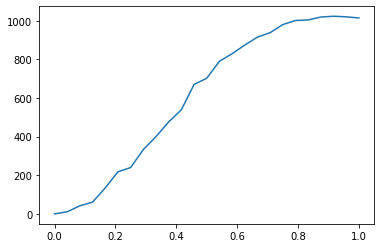

In [48]:
plt.plot(amps,counts)